<a href="https://colab.research.google.com/github/eternal-spring/ml-course/blob/main/homeworks/task05_ensemble_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- ✅ Найти данные размера хотя бы 10000, на которых можно решить задачу классификации или регрессии.
- ✅ Выполнить разведочный анализ (**EDA**). При необходимости выполнить полезные преобразования данных.
- ✅ Самостоятельно реализуйте алгоритмы **Bagging** и **AdaBoost**, которые позволят обучить ансамбли каких-то простых моделей, например деревьев принятия решений.
- ✅ Обучите ансамбли для каких-то простых моделей, используя свои две реализации, а также реализации из **sklearn** (**Bagging**, **Random Forest**, **AdaBoost**, **Gradient Tree Boosting**, **Histogram-Based Gradient Boosting**).
- ✅ При обучении использовать **подбор гиперпараметров**, **кросс-валидацию**.
- ✅ Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества, построить матрицы ошибок.
- ✅ \* (**+2 балла**) Также добавить в сравнение модели из библиотек **XGBoost**, **LightGBM** и **CatBoost**.
- ✅ \* (**+3 балла**) Для подбора гиперпараметров использовать фреймворк **Optuna**.

In [ ]:
!pip install catboost
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
%matplotlib inline
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')  # отключаем предупреждения

Реализуем $Bagging$ для регрессии

In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.utils import check_X_y, resample
from sklearn.tree import DecisionTreeRegressor

class MyOwnBaggingRegressor(RegressorMixin, BaseEstimator):
  def __init__(self, estimator=DecisionTreeRegressor(), n_estimators=10, max_samples=0.1):
    self.estimator = estimator
    self.n_estimators = n_estimators
    self.max_samples = max_samples

  def fit(self, X, y):
    self.estimators_ = []

    n_samples = int(self.max_samples * X.shape[0])

    for _ in range(self.n_estimators):
      estimator = clone(self.estimator)
      X_resampled, y_resampled = resample(X, y, n_samples=n_samples, random_state=1488)
      estimator.fit(X_resampled, y_resampled)
      self.estimators_.append(estimator)

    return self

  def predict(self, X):
    predictions = np.array([estimator.predict(X) for estimator in self.estimators_])
    return np.mean(predictions, axis=0)

Реализуем алгоритм $AdaBoost \ R2$ для регрессии:



*   Инициализируем веса образцов $w_i = \displaystyle\frac{1}{N}$, где $N$ $-$ число образцов в обучающей выборке
*   Для всех $t = 1, \dots, T$, где $T$ $-$ число базовых алгоритмов:
  * Слабый регрессор $h_t$ обучается на данных $(X, y)$ с весами $w_i$
  * Вычисляется ошибка $e_i = \lvert y_i - h_t(x_i) \rvert$
  * Ошибка нормализуется: $\displaystyle\tilde e_i = \frac{e_i}{\displaystyle\max_{i}({e_i})}$
  * Рассчитывается взвешенная ошибка регрессора $\overline{e_t} = \displaystyle\sum_{i=1}^N w_i \tilde e_i$
  * Вычисляется коэффициент $\beta_t = \displaystyle\frac{\overline{e_t}}{1 - \overline{e_t}}$
  * Вычисляется вес регрессора $\displaystyle w^{(t)} = \eta \ln(\frac{1}{\beta_t})$, где $\eta$ $-$ скорость обучения
  * Обновляются веса образцов: $\displaystyle w_i = w_i \beta_i^{1 - \tilde e_i}$
  * Веса нормализуются: $\displaystyle w_i = \frac{w_i}{\sum_{i=1}^N {w_i}}$
*Для каждого образца $x_{test}$ из тестовой выборки $X_{test}$:
  * Каждый обученный регрессор $h_t$ производит предсказание $h_t(x_{test})$
  * Предсказания $h_t(x_{test})$ сортируются по убыванию
  * Итоговое предсказание $-$ взвешенная медиана (предсказание регрессора, для которого кумулятивная сумма весов превышает половину общей суммы):
  $\displaystyle \text{WeightedMedian}(x_{test}) = \text{argmin}_p \left\{ \sum_{t: h_t(x_{test}) \leq p} w^{(t)} \geq \frac{\sum_{t=1}^T w^{(t)}}{2} \right\}$


In [ ]:
class MyOwnAdaBoostRegressor(RegressorMixin, BaseEstimator):
  def __init__(self, estimator=DecisionTreeRegressor(max_depth=3), n_estimators=10, learning_rate=1.0):
    self.estimator = estimator
    self.n_estimators = n_estimators
    self.learning_rate = learning_rate

  def fit(self, X, y):
    self.estimators_ = []
    self.estimator_weights_ = np.zeros(self.n_estimators)
    n = X.shape[0]
    sample_weights = np.ones(n) / n
    X, y = check_X_y(X, y, y_numeric=True)

    for i in range(self.n_estimators):
      estimator = clone(self.estimator)
      estimator.fit(X, y, sample_weight=sample_weights)
      y_pred = estimator.predict(X)

      error = np.abs(y - y_pred)
      max_error  = error.max()
      if max_error != 0:
        error /= max_error
      estimator_error = sample_weights @ error

      if estimator_error >= 0.5:
        if len(self.estimators_) > 1:
          self.estimators_.pop(-1)
        break

      beta = estimator_error / (1 - estimator_error)
      estimator_weight = self.learning_rate * np.log(1 / beta)

      sample_weights *= beta ** (1 - error)
      sample_weights /= sample_weights.sum()

      self.estimators_.append(estimator)
      self.estimator_weights_[i] = estimator_weight

    return self

  def predict(self, X):
    predictions = np.array([estimator.predict(X) for estimator in self.estimators_]).T

    sorted_preds = np.argsort(predictions, axis=1)

    cum_weights = np.array(self.estimator_weights_)[sorted_preds].cumsum(axis=1)
    over_median = cum_weights >= 0.5 * sum(self.estimator_weights_)
    median_idx = over_median.argmax(axis=1)

    median_preds = sorted_preds[np.arange(X.shape[0]), median_idx]

    return predictions[np.arange(X.shape[0]), median_preds]

Рассмотрим [датасет](https://www.kaggle.com/datasets/harlfoxem/housesalesprediction/data) для предсказания стоимости домов в King County, USA.

id - Unique ID for each home sold

date - Date of the home sale

price - Price of each home sold $-$ **целевой признак**

bedrooms - Number of bedrooms

bathrooms - Number of bathrooms, where .5 accounts for a room with a toilet but no shower

sqft_living - Square footage of the apartments interior living space

sqft_lot - Square footage of the land space

floors - Number of floors

waterfront - A dummy variable for whether the apartment was
overlooking the waterfront or not

view - An index from 0 to 4 of how good the view of the property was

condition - An index from 1 to 5 on the condition of the apartment,

grade - An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design.

sqft_above - The square footage of the interior housing space that is above ground level

sqft_basement - The square footage of the interior housing space that is below ground level

yr_built - The year the house was initially built

yr_renovated - The year of the house’s last renovation

zipcode - What zipcode area the house is in

lat - Lattitude

long - Longitude

sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors

sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors

# Разведочный анализ

(Из [задачи 2](https://colab.research.google.com/drive/1t3VU2zUPUTBWLs-ULgn178U6-uDZCYwu?usp=sharing))

In [ ]:
df = pd.read_csv('/content/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [ ]:
df = df.drop(columns=['id', 'date'])
df.shape

(21613, 19)

In [ ]:
pd.set_option('display.max_columns', 40)
%precision %8.8g
# df = df.round(decimals=0)
df.describe(include='all').apply(lambda s: s.apply(lambda x: format(x, '.7g')))

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21613,21613,21613,21613,21613,21613,21613,21613,21613,21613,21613,21613,21613,21613,21613,21613,21613,21613,21613
mean,540088.1,3.370842,2.114757,2079.9,15106.97,1.494309,0.007541757,0.2343034,3.40943,7.656873,1788.391,291.509,1971.005,84.40226,98077.94,47.56005,-122.2139,1986.552,12768.46
std,367127.2,0.9300618,0.7701632,918.4409,41420.51,0.5399889,0.0865172,0.7663176,0.650743,1.175459,828.091,442.575,29.37341,401.6792,53.50503,0.1385637,0.1408283,685.3913,27304.18
min,75000,0,0,290,520,1,0,0,1,1,290,0,1900,0,98001,47.1559,-122.519,399,651
25%,321950,3,1.75,1427,5040,1,0,0,3,7,1190,0,1951,0,98033,47.471,-122.328,1490,5100
50%,450000,3,2.25,1910,7618,1.5,0,0,3,7,1560,0,1975,0,98065,47.5718,-122.23,1840,7620
75%,645000,4,2.5,2550,10688,2,0,0,4,8,2210,560,1997,0,98118,47.678,-122.125,2360,10083
max,7700000,33,8,13540,1651359,3.5,1,4,5,13,9410,4820,2015,2015,98199,47.7776,-121.315,6210,871200


<Axes: xlabel='bedrooms', ylabel='count'>

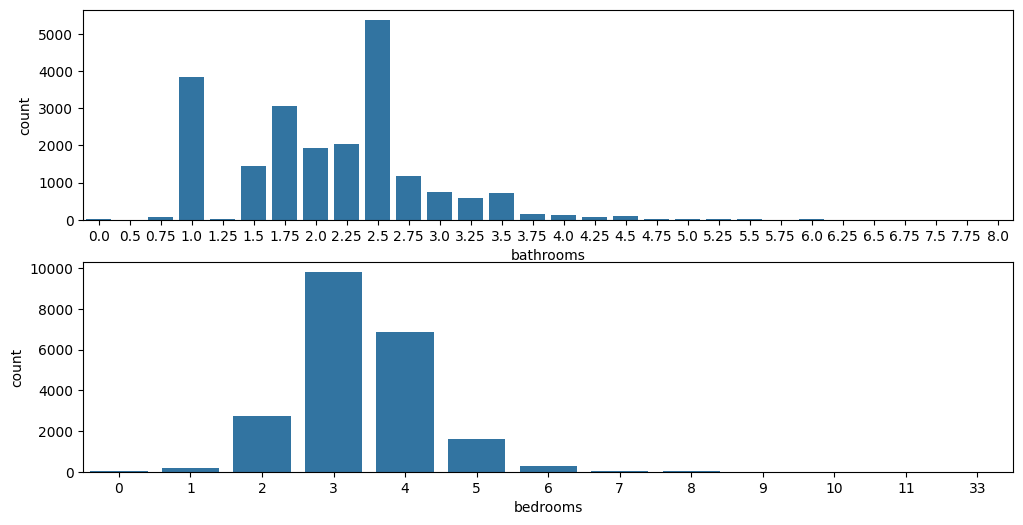

In [ ]:
_, ax = plt.subplots(2, 1, figsize=(12,6))
sns.countplot(data=df, x='bathrooms', ax=ax[0])
sns.countplot(data=df, x='bedrooms', ax=ax[1])

Видим дом с 33 спальнями, похоже опечатка, заменим на 3

In [ ]:
df[df.bedrooms == 33]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15870,640000.0,33,1.75,1620,6000,1.0,0,0,5,7,1040,580,1947,0,98103,47.6878,-122.331,1330,4700


In [ ]:
df.loc[df.bedrooms == 33, 'bedrooms'] = 3

Удалим дома без спален и санузлов

In [ ]:
df[df.bedrooms == 0]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
875,1095000.0,0,0.00,3064,4764,3.5,0,2,3,7,3064,0,1990,0,98102,47.6362,-122.322,2360,4000
3119,380000.0,0,0.00,1470,979,3.0,0,2,3,8,1470,0,2006,0,98133,47.7145,-122.356,1470,1399
3467,288000.0,0,1.50,1430,1650,3.0,0,0,3,7,1430,0,1999,0,98125,47.7222,-122.290,1430,1650
4868,228000.0,0,1.00,390,5900,1.0,0,0,2,4,390,0,1953,0,98118,47.5260,-122.261,2170,6000
6994,1295650.0,0,0.00,4810,28008,2.0,0,0,3,12,4810,0,1990,0,98053,47.6642,-122.069,4740,35061
8477,339950.0,0,2.50,2290,8319,2.0,0,0,3,8,2290,0,1985,0,98042,47.3473,-122.151,2500,8751
8484,240000.0,0,2.50,1810,5669,2.0,0,0,3,7,1810,0,2003,0,98038,47.3493,-122.053,1810,5685
9773,355000.0,0,0.00,2460,8049,2.0,0,0,3,8,2460,0,1990,0,98031,47.4095,-122.168,2520,8050
9854,235000.0,0,0.00,1470,4800,2.0,0,0,3,7,1470,0,1996,0,98065,47.5265,-121.828,1060,7200
12653,320000.0,0,2.50,1490,7111,2.0,0,0,3,7,1490,0,1999,0,98065,47.5261,-121.826,1500,4675


In [ ]:
df[df.bathrooms == 0]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
875,1095000.0,0,0.0,3064,4764,3.5,0,2,3,7,3064,0,1990,0,98102,47.6362,-122.322,2360,4000
1149,75000.0,1,0.0,670,43377,1.0,0,0,3,3,670,0,1966,0,98022,47.2638,-121.906,1160,42882
3119,380000.0,0,0.0,1470,979,3.0,0,2,3,8,1470,0,2006,0,98133,47.7145,-122.356,1470,1399
5832,280000.0,1,0.0,600,24501,1.0,0,0,2,3,600,0,1950,0,98045,47.5316,-121.749,990,22549
6994,1295650.0,0,0.0,4810,28008,2.0,0,0,3,12,4810,0,1990,0,98053,47.6642,-122.069,4740,35061
9773,355000.0,0,0.0,2460,8049,2.0,0,0,3,8,2460,0,1990,0,98031,47.4095,-122.168,2520,8050
9854,235000.0,0,0.0,1470,4800,2.0,0,0,3,7,1470,0,1996,0,98065,47.5265,-121.828,1060,7200
10481,484000.0,1,0.0,690,23244,1.0,0,0,4,7,690,0,1948,0,98053,47.6429,-121.955,1690,19290
14423,139950.0,0,0.0,844,4269,1.0,0,0,4,7,844,0,1913,0,98001,47.2781,-122.250,1380,9600
19452,142000.0,0,0.0,290,20875,1.0,0,0,1,1,290,0,1963,0,98024,47.5308,-121.888,1620,22850


In [ ]:
df.drop(df[df.bedrooms == 0].index, inplace=True)
df.drop(df[df.bathrooms == 0].index, inplace=True)

In [ ]:
len(df[df.yr_renovated > 0])

914

Удалим признак yr_renovated и создадим бинарный признак renovated

In [ ]:
df['renovated'] = 0
df.loc[df.yr_renovated > 0, 'renovated'] = 1
df = df.drop(columns=['yr_renovated'])
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,renovated
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,98178,47.5112,-122.257,1340,5650,0
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,98125,47.7210,-122.319,1690,7639,1
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,98028,47.7379,-122.233,2720,8062,0
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,98136,47.5208,-122.393,1360,5000,0
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,98074,47.6168,-122.045,1800,7503,0


<Axes: ylabel='price'>

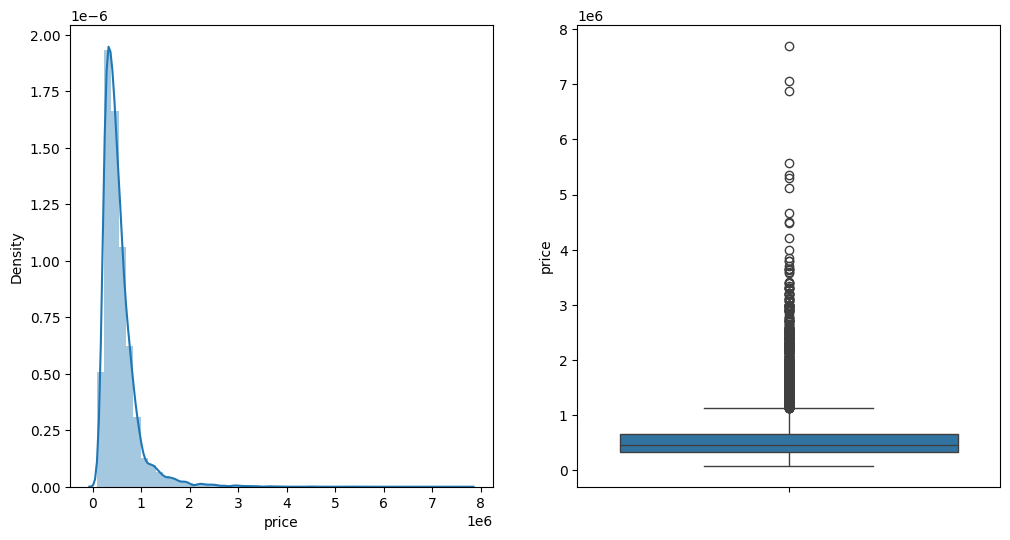

In [ ]:
_, ax = plt.subplots(1, 2, figsize=(12,6))
sns.distplot(df.price, ax=ax[0])
sns.boxplot(df.price, ax=ax[1])

Видим сильный перекос вправо

<Axes: xlabel='zipcode', ylabel='price'>

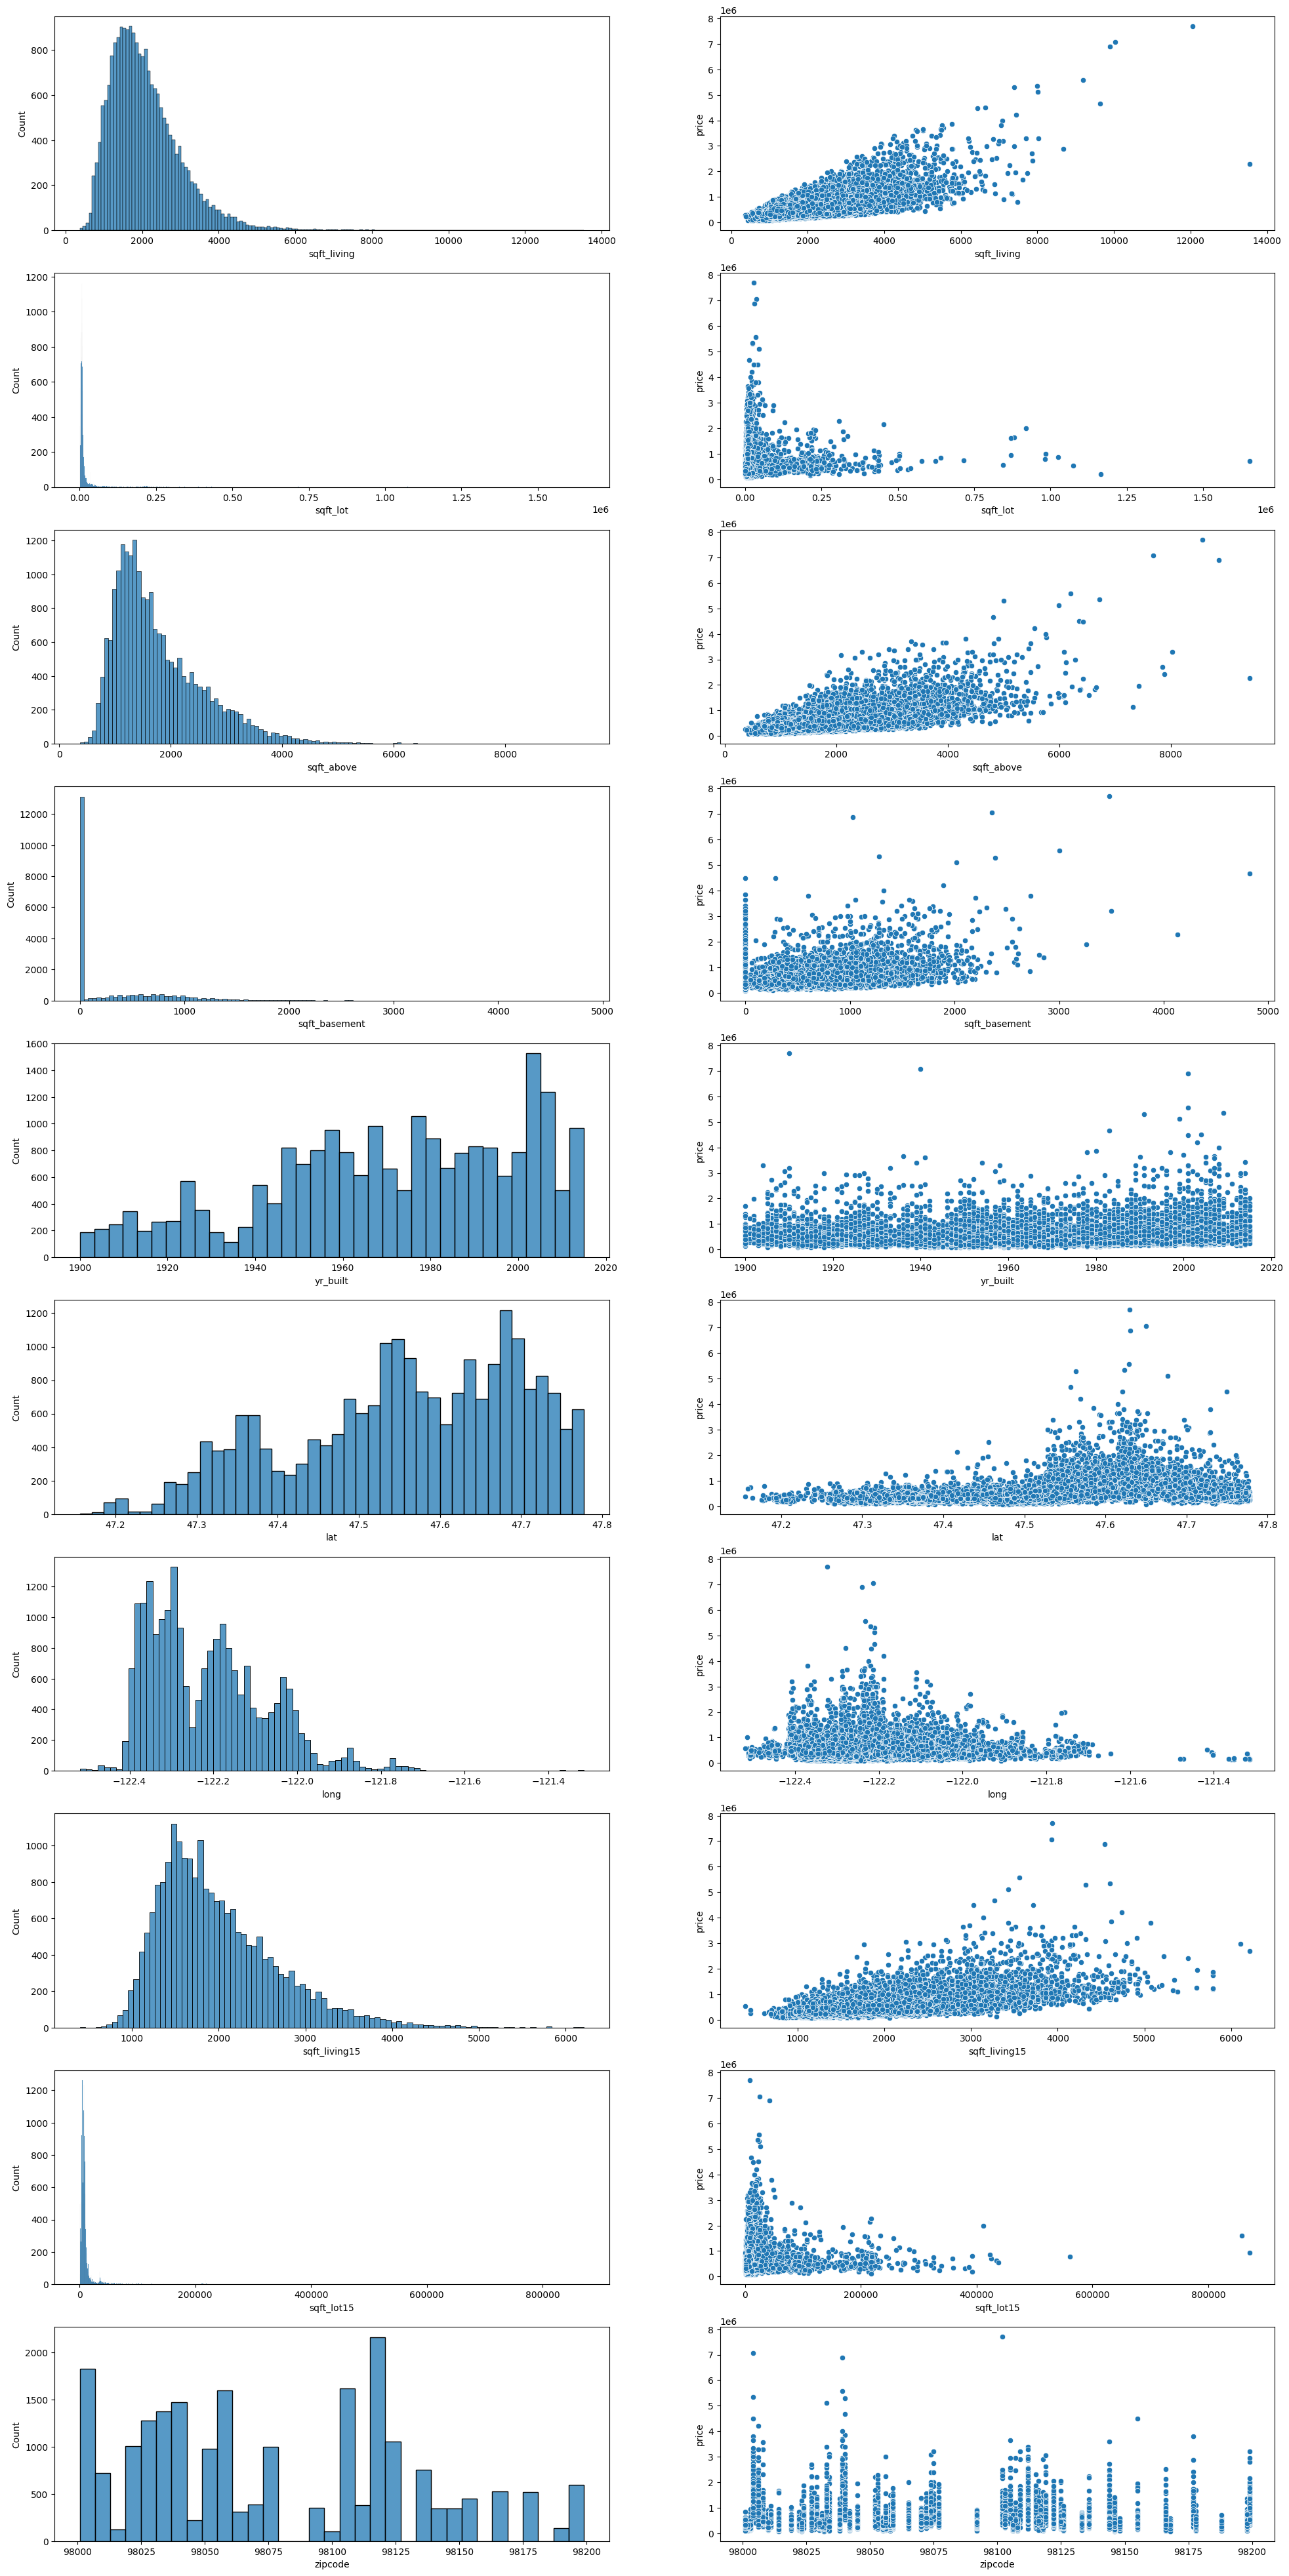

In [ ]:
_, ax = plt.subplots(10, 2, figsize=(24, 50))
sns.histplot(df.sqft_living, ax=ax[0,0])
sns.scatterplot(df, x="sqft_living", y="price", ax=ax[0,1])
sns.histplot(df.sqft_lot, ax=ax[1,0])
sns.scatterplot(df, x="sqft_lot", y="price", ax=ax[1,1])
sns.histplot(df.sqft_above, ax=ax[2,0])
sns.scatterplot(df, x="sqft_above", y="price", ax=ax[2,1])
sns.histplot(df.sqft_basement, ax=ax[3,0])
sns.scatterplot(df, x="sqft_basement", y="price", ax=ax[3,1])
sns.histplot(df.yr_built, ax=ax[4,0])
sns.scatterplot(df, x="yr_built", y="price", ax=ax[4,1])
sns.histplot(df.lat, ax=ax[5,0])
sns.scatterplot(df, x="lat", y="price", ax=ax[5,1])
sns.histplot(df.long, ax=ax[6,0])
sns.scatterplot(df, x="long", y="price", ax=ax[6,1])
sns.histplot(df.sqft_living15, ax=ax[7,0])
sns.scatterplot(df, x="sqft_living15", y="price", ax=ax[7,1])
sns.histplot(df.sqft_lot15, ax=ax[8,0])
sns.scatterplot(df, x="sqft_lot15", y="price", ax=ax[8,1])
sns.histplot(df.zipcode, ax=ax[9,0])
sns.scatterplot(df, x="zipcode", y="price", ax=ax[9,1])

Видна связь цены с признаками sqrt_living, sqrt_above, lat, sqrt_living15

Удалим выбросы

In [ ]:
df[df.sqft_living > 13000]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,renovated
12777,2280000.0,7,8.0,13540,307752,3.0,0,4,3,12,9410,4130,1999,98053,47.6675,-121.986,4850,217800,0


In [ ]:
df.drop(df[df.sqft_living > 13000].index, inplace=True)

In [ ]:
df[df.sqft_lot > 1.5e6]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,renovated
1719,700000.0,4,1.0,1300,1651359,1.0,0,3,4,6,1300,0,1920,98022,47.2313,-122.023,2560,425581,0


In [ ]:
df.drop(df[df.sqft_lot > 1.5e6].index, inplace=True)

Создадим бинарный признак basement

<Axes: xlabel='basement', ylabel='price'>

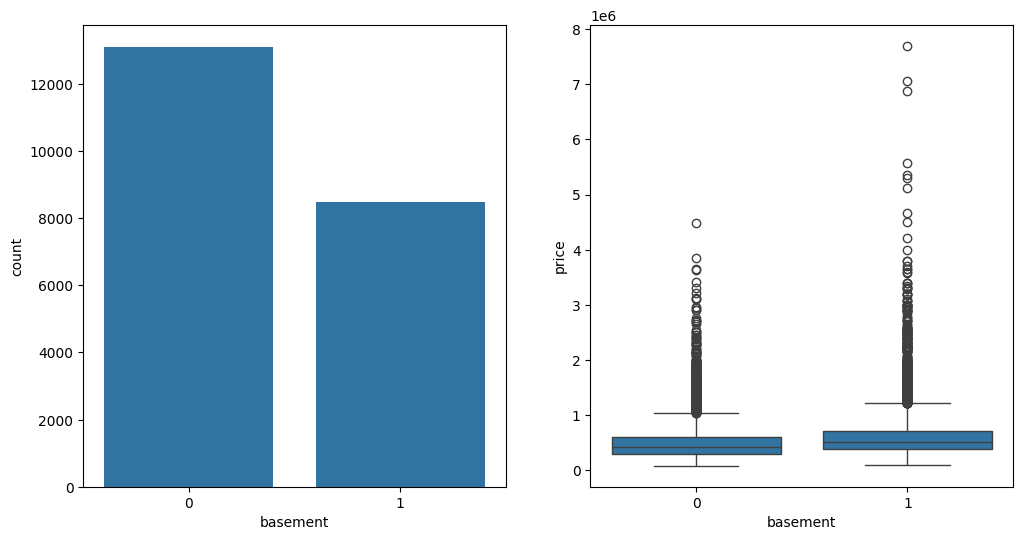

In [ ]:
df['basement'] = 0
df.loc[df.sqft_basement > 0, 'basement'] = 1
_, ax = plt.subplots(1, 2, figsize=(12,6))
sns.countplot(df, x='basement', ax=ax[0])
sns.boxplot(df, x="basement", y="price", ax=ax[1])

Видно, что у домов, имеющих подвал цена в среднем выше

In [ ]:
df = df.drop(columns=['sqft_basement'])

<Axes: xlabel='grade', ylabel='price'>

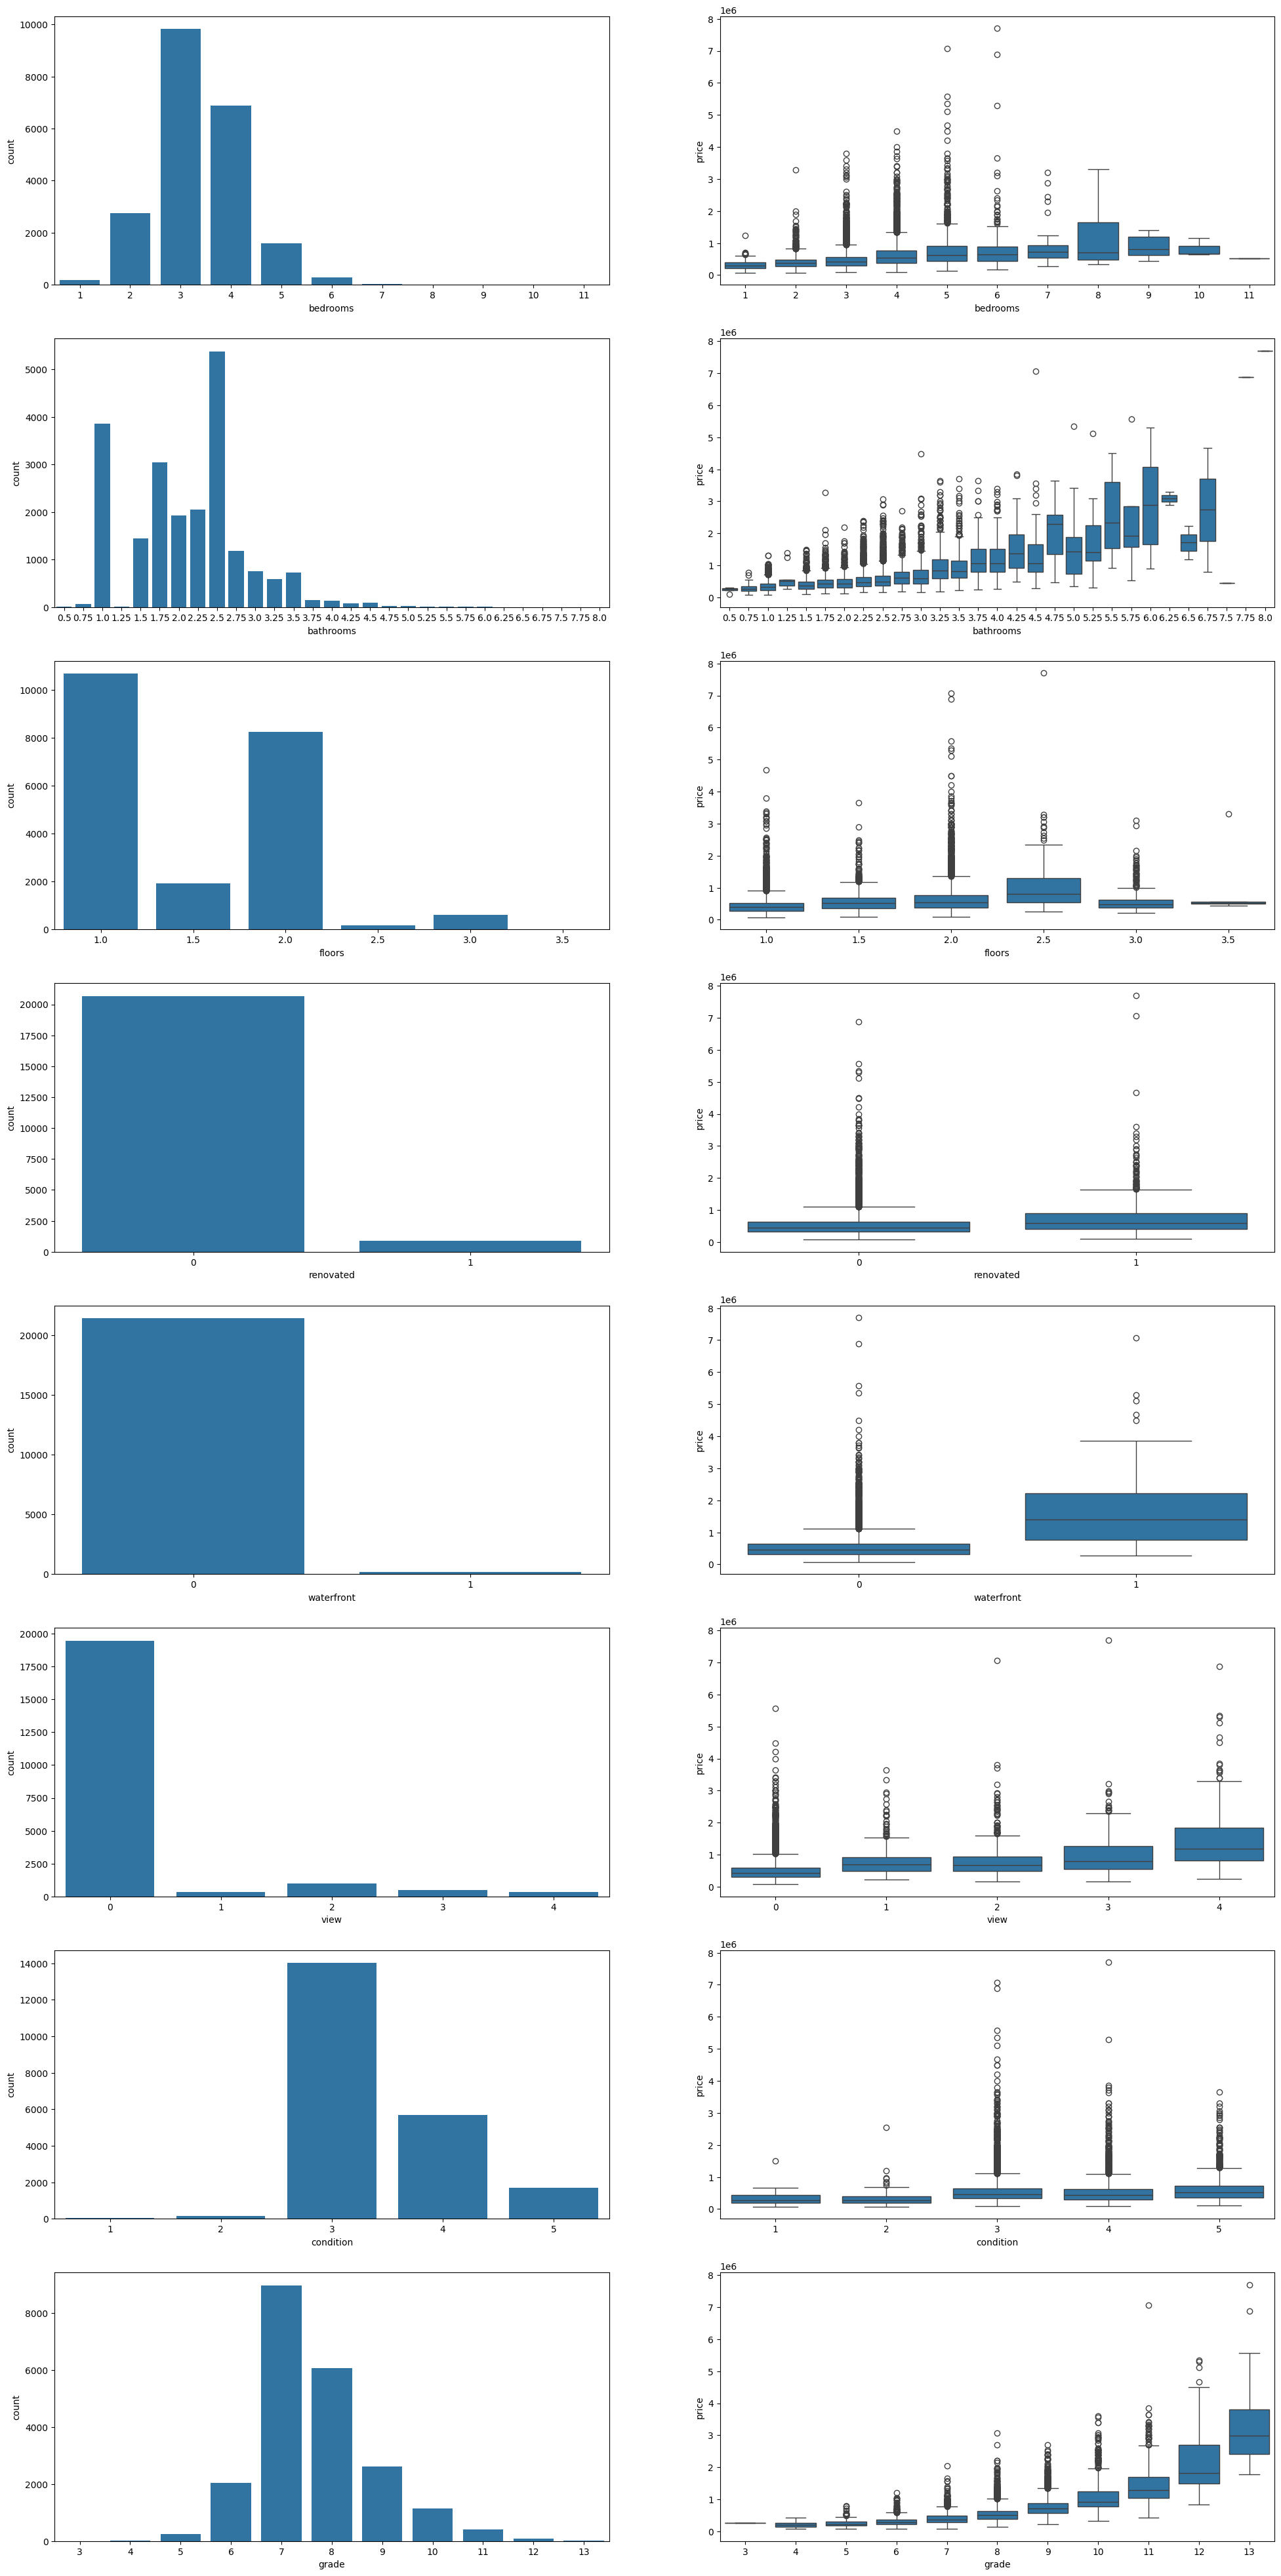

In [ ]:
_, ax = plt.subplots(8, 2, figsize=(24, 50))
sns.countplot(df, x="bedrooms", ax=ax[0,0])
sns.boxplot(df, x="bedrooms", y="price", ax=ax[0,1])
sns.countplot(df, x="bathrooms", ax=ax[1,0])
sns.boxplot(df, x="bathrooms", y="price", ax=ax[1,1])
sns.countplot(df, x="floors", ax=ax[2,0])
sns.boxplot(df, x="floors", y="price", ax=ax[2,1])
sns.countplot(df, x="renovated", ax=ax[3,0])
sns.boxplot(df, x="renovated", y="price", ax=ax[3,1])
sns.countplot(df, x="waterfront", ax=ax[4,0])
sns.boxplot(df, x="waterfront", y="price", ax=ax[4,1])
sns.countplot(df, x="view", ax=ax[5,0])
sns.boxplot(df, x="view", y="price", ax=ax[5,1])
sns.countplot(df, x="condition", ax=ax[6,0])
sns.boxplot(df, x="condition", y="price", ax=ax[6,1])
sns.countplot(df, x="grade", ax=ax[7,0])
sns.boxplot(df, x="grade", y="price", ax=ax[7,1])

Видна связь цены с признаками bedrooms, bathrooms, waterfront, view, grade

Удалим дубликаты

In [ ]:
df[df.duplicated()]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,renovated,basement
3951,550000.0,4,1.75,2410,8447,2.0,0,3,4,8,2060,1936,98074,47.6499,-122.088,2520,14789,1,1
4352,259950.0,2,2.00,1070,649,2.0,0,0,3,9,720,2008,98106,47.5213,-122.357,1070,928,0,1
14983,585000.0,3,2.50,2290,5089,2.0,0,0,3,9,2290,2001,98006,47.5443,-122.172,2290,7984,0,0
20054,555000.0,3,2.50,1940,3211,2.0,0,0,3,8,1940,2009,98027,47.5644,-122.093,1880,3078,0,0
20524,529500.0,3,2.25,1410,905,3.0,0,0,3,9,1410,2014,98116,47.5818,-122.402,1510,1352,0,0


In [ ]:
df.drop(df[df.duplicated()].index, inplace=True)

# Разбиение

In [ ]:
from sklearn.model_selection import train_test_split

y = df["price"]
X = df.drop(columns=["price"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1488)

# Обучение моделей

In [ ]:
from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
import optuna
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

Подбор гиперпараметров с кросс-валидацией с помощью Optuna

In [ ]:
def optuna_optimization(model_class, param_distributions, X, y, scoring='r2', cv=5, n_trials=50, direction='maximize'):
    def objective(trial):
        params = {key: distribution(trial) for key, distribution in param_distributions.items()}
        model = model_class(**params)
        score = cross_val_score(model, X, y, scoring=scoring, cv=cv, n_jobs=-1).mean()

        return score

    study = optuna.create_study(direction=direction)
    study.optimize(objective, n_trials=n_trials)

    best_params = study.best_trial.params
    best_score = study.best_trial.value

    print("Best hyperparameters:", best_params)
    print("Best score:", best_score)

    return best_params, best_score

In [ ]:
my_bagging_distributions = {
    "n_estimators": lambda trial: trial.suggest_int("n_estimators", 10, 50),
    "max_samples": lambda trial: trial.suggest_loguniform("max_samples", 0.1, 0.3),
}

best_params_my_bagging, best_score_my_bagging = optuna_optimization(
    model_class=MyOwnBaggingRegressor,
    param_distributions=my_bagging_distributions,
    X=X_train,
    y=y_train,
    scoring='r2',
    cv=5,
    n_trials=50,
    direction='maximize'
)

[I 2024-11-14 16:33:10,482] A new study created in memory with name: no-name-7fa36896-3158-4c84-84ea-7f482b53a1f9
[I 2024-11-14 16:33:18,373] Trial 0 finished with value: 0.6260561100996667 and parameters: {'n_estimators': 49, 'max_samples': 0.10202088952813304}. Best is trial 0 with value: 0.6260561100996667.
[I 2024-11-14 16:33:20,620] Trial 1 finished with value: 0.6798664305616399 and parameters: {'n_estimators': 12, 'max_samples': 0.21908133594501533}. Best is trial 1 with value: 0.6798664305616399.
[I 2024-11-14 16:33:22,150] Trial 2 finished with value: 0.6473824744699014 and parameters: {'n_estimators': 11, 'max_samples': 0.1519938747902612}. Best is trial 1 with value: 0.6798664305616399.
[I 2024-11-14 16:33:28,328] Trial 3 finished with value: 0.6989797870596903 and parameters: {'n_estimators': 23, 'max_samples': 0.25217706322654765}. Best is trial 3 with value: 0.6989797870596903.
[I 2024-11-14 16:33:38,302] Trial 4 finished with value: 0.676121627146965 and parameters: {'n_

Best hyperparameters: {'n_estimators': 29, 'max_samples': 0.25643756885924035}
Best score: 0.7042916315596912


In [ ]:
my_adaboost_distributions = {
    "n_estimators": lambda trial: trial.suggest_int("n_estimators", 10, 50),
    "learning_rate": lambda trial: trial.suggest_loguniform("learning_rate", 0.1, 1.0),
}

best_params_my_adaboost, best_score_my_adaboost = optuna_optimization(
    model_class=MyOwnAdaBoostRegressor,
    param_distributions=my_adaboost_distributions,
    X=X_train,
    y=y_train,
    scoring='r2',
    cv=5,
    n_trials=50,
    direction='maximize'
)

[I 2024-11-14 16:37:54,693] A new study created in memory with name: no-name-47250d3c-e20a-4f23-b870-8a499987a2d2
[I 2024-11-14 16:37:59,581] Trial 0 finished with value: 0.41807072386145927 and parameters: {'n_estimators': 32, 'learning_rate': 0.14457785174773974}. Best is trial 0 with value: 0.41807072386145927.
[I 2024-11-14 16:38:03,228] Trial 1 finished with value: 0.5076775659167491 and parameters: {'n_estimators': 24, 'learning_rate': 0.8931179312787206}. Best is trial 1 with value: 0.5076775659167491.
[I 2024-11-14 16:38:07,808] Trial 2 finished with value: 0.5081343900322457 and parameters: {'n_estimators': 24, 'learning_rate': 0.17195822644707356}. Best is trial 2 with value: 0.5081343900322457.
[I 2024-11-14 16:38:15,709] Trial 3 finished with value: 0.2029777401691928 and parameters: {'n_estimators': 50, 'learning_rate': 0.3746320394758787}. Best is trial 2 with value: 0.5081343900322457.
[I 2024-11-14 16:38:24,101] Trial 4 finished with value: 0.2315148656663919 and parame

Best hyperparameters: {'n_estimators': 10, 'learning_rate': 0.20694517013024535}
Best score: 0.6361727151254011


In [ ]:
bagging_distributions = {
    "n_estimators": lambda trial: trial.suggest_int("n_estimators", 10, 50),
    "max_samples": lambda trial: trial.suggest_loguniform("max_samples", 0.1, 0.3),
}

best_params_bagging, best_score_bagging = optuna_optimization(
    model_class=BaggingRegressor,
    param_distributions=bagging_distributions,
    X=X_train,
    y=y_train,
    scoring='r2',
    cv=5,
    n_trials=50,
    direction='maximize'
)

[I 2024-11-14 16:40:49,430] A new study created in memory with name: no-name-3b2b9489-93c1-4c6d-95c9-e7151f7e418c
[I 2024-11-14 16:40:54,292] Trial 0 finished with value: 0.8370986397683072 and parameters: {'n_estimators': 20, 'max_samples': 0.2003675864841708}. Best is trial 0 with value: 0.8370986397683072.
[I 2024-11-14 16:40:57,166] Trial 1 finished with value: 0.8353819451276501 and parameters: {'n_estimators': 25, 'max_samples': 0.13900940266217474}. Best is trial 0 with value: 0.8370986397683072.
[I 2024-11-14 16:41:03,920] Trial 2 finished with value: 0.8473664055009327 and parameters: {'n_estimators': 35, 'max_samples': 0.2406864017467275}. Best is trial 2 with value: 0.8473664055009327.
[I 2024-11-14 16:41:09,165] Trial 3 finished with value: 0.8366150752380648 and parameters: {'n_estimators': 23, 'max_samples': 0.17591686825011368}. Best is trial 2 with value: 0.8473664055009327.
[I 2024-11-14 16:41:10,600] Trial 4 finished with value: 0.8151690137819415 and parameters: {'n_

Best hyperparameters: {'n_estimators': 38, 'max_samples': 0.2850860867470359}
Best score: 0.8556447268043039


In [ ]:
adaboost_distributions = {
    "n_estimators": lambda trial: trial.suggest_int("n_estimators", 10, 50),
    "learning_rate": lambda trial: trial.suggest_loguniform("learning_rate", 0.1, 1.0),
}

best_params_adaboost, best_score_adaboost = optuna_optimization(
    model_class=AdaBoostRegressor,
    param_distributions=adaboost_distributions,
    X=X_train,
    y=y_train,
    scoring='r2',
    cv=5,
    n_trials=50,
    direction='maximize'
)

[I 2024-11-14 16:47:23,954] A new study created in memory with name: no-name-867c6246-85ec-4ec2-8847-a44a898ab3ff
[I 2024-11-14 16:47:26,785] Trial 0 finished with value: 0.6519533868234557 and parameters: {'n_estimators': 19, 'learning_rate': 0.15047056066965056}. Best is trial 0 with value: 0.6519533868234557.
[I 2024-11-14 16:47:32,739] Trial 1 finished with value: 0.5685242441242183 and parameters: {'n_estimators': 46, 'learning_rate': 0.449917853362761}. Best is trial 0 with value: 0.6519533868234557.
[I 2024-11-14 16:47:37,966] Trial 2 finished with value: 0.671707970402921 and parameters: {'n_estimators': 26, 'learning_rate': 0.21230684819176088}. Best is trial 2 with value: 0.671707970402921.
[I 2024-11-14 16:47:40,266] Trial 3 finished with value: 0.6502665199178148 and parameters: {'n_estimators': 16, 'learning_rate': 0.5123647603695636}. Best is trial 2 with value: 0.671707970402921.
[I 2024-11-14 16:47:45,032] Trial 4 finished with value: 0.45938688068282546 and parameters:

Best hyperparameters: {'n_estimators': 31, 'learning_rate': 0.17212877114014108}
Best score: 0.6765042611184272


In [ ]:
random_forest_distributions = {
    "n_estimators": lambda trial: trial.suggest_int("n_estimators", 10, 100),
    "max_features": lambda trial: trial.suggest_loguniform("max_features", 0.1, 1.0),
}

best_params_random_forest, best_score_random_forest = optuna_optimization(
    model_class=RandomForestRegressor,
    param_distributions=random_forest_distributions,
    X=X_train,
    y=y_train,
    scoring='r2',
    cv=5,
    n_trials=50,
    direction='maximize'
)

[I 2024-11-14 16:51:26,770] A new study created in memory with name: no-name-edf9dc97-e88b-4a34-8994-d79c5eb08ab8
[I 2024-11-14 16:51:39,869] Trial 0 finished with value: 0.8554980771686413 and parameters: {'n_estimators': 81, 'max_features': 0.20364612321278971}. Best is trial 0 with value: 0.8554980771686413.
[I 2024-11-14 16:51:50,011] Trial 1 finished with value: 0.8629820794308017 and parameters: {'n_estimators': 38, 'max_features': 0.36122643672041316}. Best is trial 1 with value: 0.8629820794308017.
[I 2024-11-14 16:51:58,246] Trial 2 finished with value: 0.8580575698726784 and parameters: {'n_estimators': 51, 'max_features': 0.26925224527845154}. Best is trial 1 with value: 0.8629820794308017.
[I 2024-11-14 16:51:59,298] Trial 3 finished with value: 0.7770756661298659 and parameters: {'n_estimators': 11, 'max_features': 0.10588856534204105}. Best is trial 1 with value: 0.8629820794308017.
[I 2024-11-14 16:52:05,984] Trial 4 finished with value: 0.8572855585036724 and parameters

Best hyperparameters: {'n_estimators': 93, 'max_features': 0.4652221766857802}
Best score: 0.8719250156801005


In [ ]:
gradient_boost_distributions = {
    "n_estimators": lambda trial: trial.suggest_int("n_estimators", 10, 100),
    "learning_rate": lambda trial: trial.suggest_loguniform("learning_rate", 0.1, 1.0),
}

best_params_gradient_boost, best_score_gradient_boost = optuna_optimization(
    model_class=GradientBoostingRegressor,
    param_distributions=gradient_boost_distributions,
    X=X_train,
    y=y_train,
    scoring='r2',
    cv=5,
    n_trials=50,
    direction='maximize'
)

[I 2024-11-14 17:14:45,377] A new study created in memory with name: no-name-9b8a79ff-0c8c-4a49-9c75-768b00f7897f
[I 2024-11-14 17:14:56,608] Trial 0 finished with value: 0.8676956440091775 and parameters: {'n_estimators': 71, 'learning_rate': 0.2572266523593383}. Best is trial 0 with value: 0.8676956440091775.
[I 2024-11-14 17:15:07,145] Trial 1 finished with value: 0.8633637790291475 and parameters: {'n_estimators': 69, 'learning_rate': 0.5312406960301443}. Best is trial 0 with value: 0.8676956440091775.
[I 2024-11-14 17:15:14,246] Trial 2 finished with value: 0.8589433897074505 and parameters: {'n_estimators': 55, 'learning_rate': 0.5273861872312545}. Best is trial 0 with value: 0.8676956440091775.
[I 2024-11-14 17:15:26,265] Trial 3 finished with value: 0.8505429779380824 and parameters: {'n_estimators': 78, 'learning_rate': 0.8336193235358468}. Best is trial 0 with value: 0.8676956440091775.
[I 2024-11-14 17:15:28,942] Trial 4 finished with value: 0.8295499168836123 and parameters

Best hyperparameters: {'n_estimators': 94, 'learning_rate': 0.38890996300948794}
Best score: 0.8759644589634794


In [ ]:
hist_gradient_boost_distributions = {
    "max_features": lambda trial: trial.suggest_loguniform("max_features", 0.1, 1.0),
    "learning_rate": lambda trial: trial.suggest_loguniform("learning_rate", 0.1, 1.0),
}

best_params_hist_gradient_boost, best_score_hist_gradient_boost = optuna_optimization(
    model_class=HistGradientBoostingRegressor,
    param_distributions=hist_gradient_boost_distributions,
    X=X_train,
    y=y_train,
    scoring='r2',
    cv=5,
    n_trials=50,
    direction='maximize'
)

[I 2024-11-14 17:25:26,380] A new study created in memory with name: no-name-24d551ef-cdf2-42a9-8826-2d7e8c443746
[I 2024-11-14 17:25:28,112] Trial 0 finished with value: 0.8646510408940408 and parameters: {'max_features': 0.22654306187273443, 'learning_rate': 0.1531040103172845}. Best is trial 0 with value: 0.8646510408940408.
[I 2024-11-14 17:25:30,219] Trial 1 finished with value: 0.8449725262209155 and parameters: {'max_features': 0.13663442981919222, 'learning_rate': 0.42870833572853195}. Best is trial 0 with value: 0.8646510408940408.
[I 2024-11-14 17:25:32,726] Trial 2 finished with value: 0.8669417644259292 and parameters: {'max_features': 0.21865343382355487, 'learning_rate': 0.2207906118965332}. Best is trial 2 with value: 0.8669417644259292.
[I 2024-11-14 17:25:34,662] Trial 3 finished with value: 0.8644857241497658 and parameters: {'max_features': 0.14646476212862708, 'learning_rate': 0.13885586167281228}. Best is trial 2 with value: 0.8669417644259292.
[I 2024-11-14 17:25:

Best hyperparameters: {'max_features': 0.19071313911804477, 'learning_rate': 0.12900774925587588}
Best score: 0.8732060914478479


In [ ]:
xgb_distributions = {
    "n_estimators": lambda trial: trial.suggest_int("n_estimators", 10, 100),
    "learning_rate": lambda trial: trial.suggest_loguniform("learning_rate", 0.1, 1.0),
}

best_params_xgb, best_score_xgb = optuna_optimization(
    model_class=XGBRegressor,
    param_distributions=xgb_distributions,
    X=X_train,
    y=y_train,
    scoring='r2',
    cv=5,
    n_trials=50,
    direction='maximize'
)

[I 2024-11-14 17:27:10,162] A new study created in memory with name: no-name-c9198434-fed8-49bd-8a8f-38331675d62b
[I 2024-11-14 17:27:11,737] Trial 0 finished with value: 0.8695178729042974 and parameters: {'n_estimators': 43, 'learning_rate': 0.3586100682903604}. Best is trial 0 with value: 0.8695178729042974.
[I 2024-11-14 17:27:13,937] Trial 1 finished with value: 0.8650949540764212 and parameters: {'n_estimators': 68, 'learning_rate': 0.3737166232335423}. Best is trial 0 with value: 0.8695178729042974.
[I 2024-11-14 17:27:16,175] Trial 2 finished with value: 0.875035191067832 and parameters: {'n_estimators': 90, 'learning_rate': 0.2523188053279319}. Best is trial 2 with value: 0.875035191067832.
[I 2024-11-14 17:27:17,320] Trial 3 finished with value: 0.8514135362781087 and parameters: {'n_estimators': 52, 'learning_rate': 0.49936255864933826}. Best is trial 2 with value: 0.875035191067832.
[I 2024-11-14 17:27:18,025] Trial 4 finished with value: 0.8540122102878767 and parameters: 

Best hyperparameters: {'n_estimators': 99, 'learning_rate': 0.1664374675259359}
Best score: 0.8811522901157884


In [ ]:
lgbm_distributions = {
    "n_estimators": lambda trial: trial.suggest_int("n_estimators", 5, 60),
    "learning_rate": lambda trial: trial.suggest_loguniform("learning_rate", 0.1, 1.0),
}

best_params_lgbm, best_score_lgbm = optuna_optimization(
    model_class=LGBMRegressor,
    param_distributions=lgbm_distributions,
    X=X_train,
    y=y_train,
    scoring='r2',
    cv=5,
    n_trials=50,
    direction='maximize'
)

[I 2024-11-14 17:54:13,101] A new study created in memory with name: no-name-91cb2a82-268e-469d-adfb-044116a95e19
[I 2024-11-14 17:54:16,577] Trial 0 finished with value: 0.8580711060682151 and parameters: {'n_estimators': 30, 'learning_rate': 0.41408249448033957}. Best is trial 0 with value: 0.8580711060682151.
[I 2024-11-14 17:54:16,976] Trial 1 finished with value: 0.7053993414252742 and parameters: {'n_estimators': 5, 'learning_rate': 0.2044091369361859}. Best is trial 0 with value: 0.8580711060682151.
[I 2024-11-14 17:54:18,313] Trial 2 finished with value: 0.8569254626877912 and parameters: {'n_estimators': 60, 'learning_rate': 0.4364318411528973}. Best is trial 0 with value: 0.8580711060682151.
[I 2024-11-14 17:54:19,409] Trial 3 finished with value: 0.8574315708393352 and parameters: {'n_estimators': 32, 'learning_rate': 0.10598793719152463}. Best is trial 0 with value: 0.8580711060682151.
[I 2024-11-14 17:54:20,392] Trial 4 finished with value: 0.8550115454393398 and parameter

Best hyperparameters: {'n_estimators': 60, 'learning_rate': 0.11552823010334534}
Best score: 0.8724500840918422


In [ ]:
catboost_distributions = {
    "iterations": lambda trial: trial.suggest_int("iterations", 10, 1000),
    "learning_rate": lambda trial: trial.suggest_loguniform("learning_rate", 0.01, 1.0),
}

best_params_catboost, best_score_catboost = optuna_optimization(
    model_class=CatBoostRegressor,
    param_distributions=catboost_distributions,
    X=X_train,
    y=y_train,
    scoring='r2',
    cv=5,
    n_trials=50,
    direction='maximize'
)

[I 2024-11-14 17:29:27,737] A new study created in memory with name: no-name-701c5b8d-a996-4c3a-93ec-4c2db8b8ad20
[I 2024-11-14 17:29:50,804] Trial 0 finished with value: 0.8897318346789843 and parameters: {'iterations': 686, 'learning_rate': 0.30450456481677557}. Best is trial 0 with value: 0.8897318346789843.
[I 2024-11-14 17:30:00,132] Trial 1 finished with value: 0.8846239892732829 and parameters: {'iterations': 222, 'learning_rate': 0.40448521798879655}. Best is trial 0 with value: 0.8897318346789843.
[I 2024-11-14 17:30:09,089] Trial 2 finished with value: 0.8499950428377655 and parameters: {'iterations': 272, 'learning_rate': 0.9442279087441487}. Best is trial 0 with value: 0.8897318346789843.
[I 2024-11-14 17:30:33,865] Trial 3 finished with value: 0.8943663827368568 and parameters: {'iterations': 643, 'learning_rate': 0.08681792992731723}. Best is trial 3 with value: 0.8943663827368568.
[I 2024-11-14 17:30:40,368] Trial 4 finished with value: 0.884535626774879 and parameters: 

Best hyperparameters: {'iterations': 874, 'learning_rate': 0.09848393187018827}
Best score: 0.8959126543651081


In [ ]:
import time

def print_metrics(model, X_train, X_test, y_train, y_test):
  start_time = time.time()
  model.fit(X_train, y_train)
  end_time = time.time()
  training_time = end_time - start_time
  print(f"Training time: {training_time:.2f} s")

  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  print("Train RMSE =", root_mean_squared_error(y_train, y_train_pred))
  print("Test RMSE =", root_mean_squared_error(y_test, y_test_pred))
  print("Train MSE =", mean_squared_error(y_train, y_train_pred))
  print("Test MSE =", mean_squared_error(y_test, y_test_pred))
  print("Train R2 =", r2_score(y_train, y_train_pred))
  print("Test R2 =", r2_score(y_test, y_test_pred))

In [ ]:
print_metrics(MyOwnBaggingRegressor(**best_params_my_bagging), X_train, X_test, y_train, y_test)

Training time: 1.72 s
Train RMSE = 175428.21193617012
Test RMSE = 187866.5559022482
Train MSE = 30775057543.121822
Test MSE = 35293842826.57254
Train R2 = 0.769553917163544
Test R2 = 0.7429757894533224


In [ ]:
print_metrics(MyOwnAdaBoostRegressor(**best_params_my_adaboost), X_train, X_test, y_train, y_test)

Training time: 0.59 s
Train RMSE = 216008.6159110464
Test RMSE = 223114.03303459196
Train MSE = 46659722147.80596
Test MSE = 49779871736.961
Train R2 = 0.6506082830183858
Test R2 = 0.6374825972570417


In [ ]:
print_metrics(BaggingRegressor(**best_params_bagging), X_train, X_test, y_train, y_test)

Training time: 2.56 s
Train RMSE = 103670.23452168705
Test RMSE = 134034.51429778285
Train MSE = 10747517525.781591
Test MSE = 17965251023.042553
Train R2 = 0.9195217324756532
Test R2 = 0.8691696882042578


In [ ]:
print_metrics(AdaBoostRegressor(**best_params_adaboost), X_train, X_test, y_train, y_test)

Training time: 1.37 s
Train RMSE = 193578.2825257277
Test RMSE = 197760.73183717002
Train MSE = 37472551465.61045
Test MSE = 39109307056.77307
Train R2 = 0.7194025490598173
Test R2 = 0.7151900171174734


In [ ]:
print_metrics(RandomForestRegressor(**best_params_random_forest), X_train, X_test, y_train, y_test)

Training time: 9.52 s
Train RMSE = 50093.02669452219
Test RMSE = 125751.09014861028
Train MSE = 2509311323.4181128
Test MSE = 15813336673.56391
Train R2 = 0.981210076884873
Test R2 = 0.8848408093558031


In [ ]:
print_metrics(GradientBoostingRegressor(**best_params_gradient_boost), X_train, X_test, y_train, y_test)

Training time: 4.07 s
Train RMSE = 94146.18150525012
Test RMSE = 125913.34217490922
Train MSE = 8863503492.019499
Test MSE = 15854169737.655773
Train R2 = 0.9336293796662729
Test R2 = 0.8845434462685932


In [ ]:
print_metrics(HistGradientBoostingRegressor(**best_params_hist_gradient_boost), X_train, X_test, y_train, y_test)

Training time: 0.86 s
Train RMSE = 91006.72011007619
Test RMSE = 119075.73203998053
Train MSE = 8282223105.193747
Test MSE = 14179029960.857246
Train R2 = 0.9379820535154106
Test R2 = 0.8967424998203026


In [ ]:
print_metrics(XGBRegressor(**best_params_xgb), X_train, X_test, y_train, y_test)

Training time: 0.39 s
Train RMSE = 66359.98708739251
Test RMSE = 112773.52709984158
Train MSE = 4403647886.2389
Test MSE = 12717868414.538704
Train R2 = 0.9670251337742307
Test R2 = 0.9073832763084025


In [ ]:
print_metrics(LGBMRegressor(**best_params_lgbm), X_train, X_test, y_train, y_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2045
[LightGBM] [Info] Number of data points in the train set: 15113, number of used features: 18
[LightGBM] [Info] Start training from score 539105.251836
Training time: 0.20 s
Train RMSE = 98009.53643336904
Test RMSE = 116926.22869598566
Train MSE = 9605869231.883894
Test MSE = 13671742957.06594
Train R2 = 0.9280704858593636
Test R2 = 0.9004367714333639


In [ ]:
print_metrics(CatBoostRegressor(**best_params_catboost), X_train, X_test, y_train, y_test)

0:	learn: 343442.8831575	total: 53.2ms	remaining: 46.5s
1:	learn: 323653.7187806	total: 58.5ms	remaining: 25.5s
2:	learn: 305414.3129218	total: 63.4ms	remaining: 18.4s
3:	learn: 288386.1184698	total: 68.5ms	remaining: 14.9s
4:	learn: 274398.4696268	total: 73.5ms	remaining: 12.8s
5:	learn: 261534.3292492	total: 79.4ms	remaining: 11.5s
6:	learn: 249427.9506751	total: 84.2ms	remaining: 10.4s
7:	learn: 238575.0633457	total: 89.6ms	remaining: 9.7s
8:	learn: 228754.6408632	total: 94.5ms	remaining: 9.08s
9:	learn: 219552.4336970	total: 99.4ms	remaining: 8.58s
10:	learn: 211680.2319290	total: 104ms	remaining: 8.18s
11:	learn: 204691.4510626	total: 109ms	remaining: 7.84s
12:	learn: 198288.3053144	total: 114ms	remaining: 7.57s
13:	learn: 192604.3656504	total: 119ms	remaining: 7.32s
14:	learn: 186990.1010518	total: 124ms	remaining: 7.11s
15:	learn: 181037.0790169	total: 129ms	remaining: 6.92s
16:	learn: 176738.1734289	total: 134ms	remaining: 6.75s
17:	learn: 172804.8757488	total: 139ms	remaining:

Выводы:


*   Мои модели показали результат хуже, чем библиотечные
*   AdaBoost показал худший результат
* Random Forest обучается дольше всех
* У CatBoost лучший результат на тестовой выборке, он же на втором месте с конца по скорости обучения
* Быстрее всех обучаются LGBM и XGM, у них также один из лучших R2
* У RandomForest, Gradient Boosting, XGB, CatBoost сильная склонность к переобучению

